I used a conda env with python 3.86

I installed spacy like this

 conda install -c conda-forge spacy
 
 conda install -c conda-forge spacy-lookups-data
 
 python -m spacy download en_core_web_sm
 
 pip install spacy-langdetect
 
 conda install -c conda-forge wordcloud

In [95]:
import pandas as pd
import numpy as np
import json
import spacy
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

In [72]:
!ls

EDA.ipynb                          adverse_media_training.csv.zip
LICENSE                            non_adverse_media_training.csv.zip
README.md


In [4]:
am = pd.read_csv('adverse_media_training.csv.zip')
nam = pd.read_csv('non_adverse_media_training.csv.zip')

### put the am and nam training data together, keep the labels - some articles from the nam file have an am label and maybe also vice versa

In [5]:
am.label.unique()

array([nan, 'am', 'delete', 'delete        ', 'random', 'nam', 'doubt',
       'neither', 'am, doubt', 'am '], dtype=object)

In [6]:
# keep only those with am label
am_confirmed = am.loc[(am.label == 'am') | (am.label == 'am ')]
am_confirmed.shape

(392, 11)

In [7]:
nam.label.unique()

array(['nam', nan, 'am', 'neither', 'random', 'doubt', 'delete'],
      dtype=object)

In [8]:
nam.loc[nam.label == 'am'].shape, am_confirmed.shape

((19, 11), (392, 11))

In [9]:
# Move rows with "am" from nam file to am df
am_confirmed = pd.concat([am_confirmed, nam.loc[nam.label == 'am']])

In [10]:
nam.label.unique()

array(['nam', nan, 'am', 'neither', 'random', 'doubt', 'delete'],
      dtype=object)

In [11]:
# keep only those with am label
nam_confirmed = nam.loc[(nam.label == 'nam') | (nam.label == 'random')]
nam_confirmed.shape

(288, 11)

In [12]:
am.loc[am.label == 'nam'].shape

(18, 11)

In [13]:
# Move rows with "nam" from am file to nam df
nam_confirmed = pd.concat([nam_confirmed, am.loc[am.label == 'nam']])
nam_confirmed.shape

(306, 11)

In [15]:
am_confirmed['is_adverse_media'] = 1
nam_confirmed['is_adverse_media'] = 0

In [19]:
# put am and nam into one DF
train = pd.concat([am_confirmed, nam_confirmed])

In [23]:
train.is_adverse_media.describe()

count    717.000000
mean       0.573222
std        0.494955
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: is_adverse_media, dtype: float64

### basic preprocessing: keep only needed columns, make sure no null values for important columns

In [30]:
# keep only needed columns
train = train.loc[:, ['entity_name', 'entity_type', 'url', 'article', 'full_response', 'explanation', 'title', 'is_adverse_media']]

train.describe(include='all')

,entity_name,entity_type,url,article,full_response,explanation,title,is_adverse_media
count,618,619,717,717,717,626,717,717.000000
unique,478,16,717,717,717,363,711,NaN
top,John McAfee,individual,https://www.thejakartapost.com/news/2013/09/21...,Nauru is banking on fields of mineral-rich smo...,[{'query': {'id': '1605055021641-edd6ff95a605a...,corruption,President Lopez Obrador urges review of U.S. d...,NaN
freq,8,176,1,1,1,34,2,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.573222
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.494955
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [34]:
# make sure all articles and labels (is_adverse_media) values are there
sum(train.article.isna()), sum(train.is_adverse_media.isna())

(0, 0)

In [74]:
# Make sure we only have English articles
 
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# test if it works
text = 'This is an english text. Ja see on eestikeelne lause. بوغيث	'
doc = nlp(text)
# document level language detection. Think of it like average language of the document!
print(doc._.language)
# sentence level language detection
for sent in doc.sents:
   print(sent, sent._.language)


{'language': 'et', 'score': 0.9999974207115989}
This is an english text. {'language': 'en', 'score': 0.9999986597446736}
Ja see on eestikeelne lause. {'language': 'et', 'score': 0.9999955746098503}
بوغيث	 {'language': 'ar', 'score': 0.9999968633428711}


In [77]:
train['article'].apply(lambda article: nlp(article)._.language['language']).unique()

array(['en'], dtype=object)

In [101]:
# From https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
# lowercase
train['cleaned']=train['article'].apply(lambda x: x.lower())

# Remove digits and words containing digits
train['cleaned']=train['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

# Remove punctuations
import string 
train['cleaned']=train['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Removing extra spaces
train['cleaned']=train['cleaned'].apply(lambda x: re.sub(' +',' ',x))


In [102]:

nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# lemmatize and remove stopwords
train['lemmatized']=train['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

train.columns

Index(['entity_name', 'entity_type', 'url', 'article', 'full_response',
       'explanation', 'title', 'is_adverse_media', 'lemmatized', 'language',
       'cleaned'],
      dtype='object')

In [103]:
am_train = train.loc[train.is_adverse_media == 1]
nam_train = train.loc[train.is_adverse_media == 0]

In [132]:
am_all_lemmas = ''.join([item for sublist in list(am_train['lemmatized']) for item in sublist])
nam_all_lemmas = ''.join([item for sublist in list(nam_train['lemmatized']) for item in sublist])

## Build word clouds for unigrams

In [170]:
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer(analyzer='word')

data=cv.fit_transform([am_all_lemmas, nam_all_lemmas])
unigram_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
unigram_dtm.index = ['adverse media', 'non adverse media']
unigram_dtm.head(3)

,aa,aaa,aaarated,aabar,aadhaar,aadhar,aadmi,aaii,aam,aane,...,بوغيث,سليمان,صالح,عقيلة,عيسى,ماهان,مصطفى,هواپیمایی,吳立勝,新建业集团
adverse media,1,1,1,1,2,2,1,1,1,0,...,1,1,0,0,0,1,0,1,1,1
non adverse media,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,1,0,1,0,0,0


In [168]:

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud

# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=800, height=660, max_words=100,colormap="Dark2", background_color='white', random_state=1).generate_from_frequencies(data)
    plt.figure(figsize=(20,16))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=13)
    plt.show()

def generate_wordclouds(df_dtm):
    # Transposing document term matrix
    df_dtm_transposed=df_dtm.transpose()

    # Plotting word cloud for each product
    for product in df_dtm_transposed.columns:
        generate_wordcloud(df_dtm_transposed[product].sort_values(ascending=False) ,product)


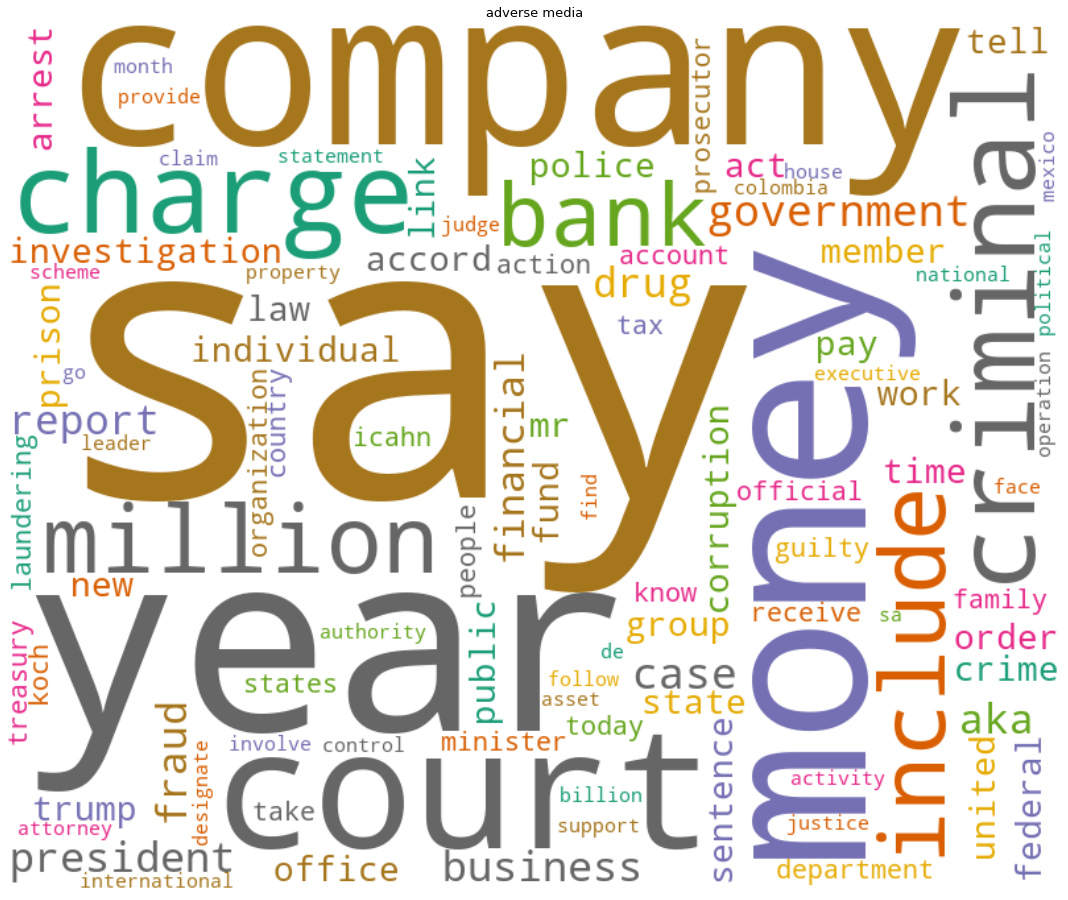

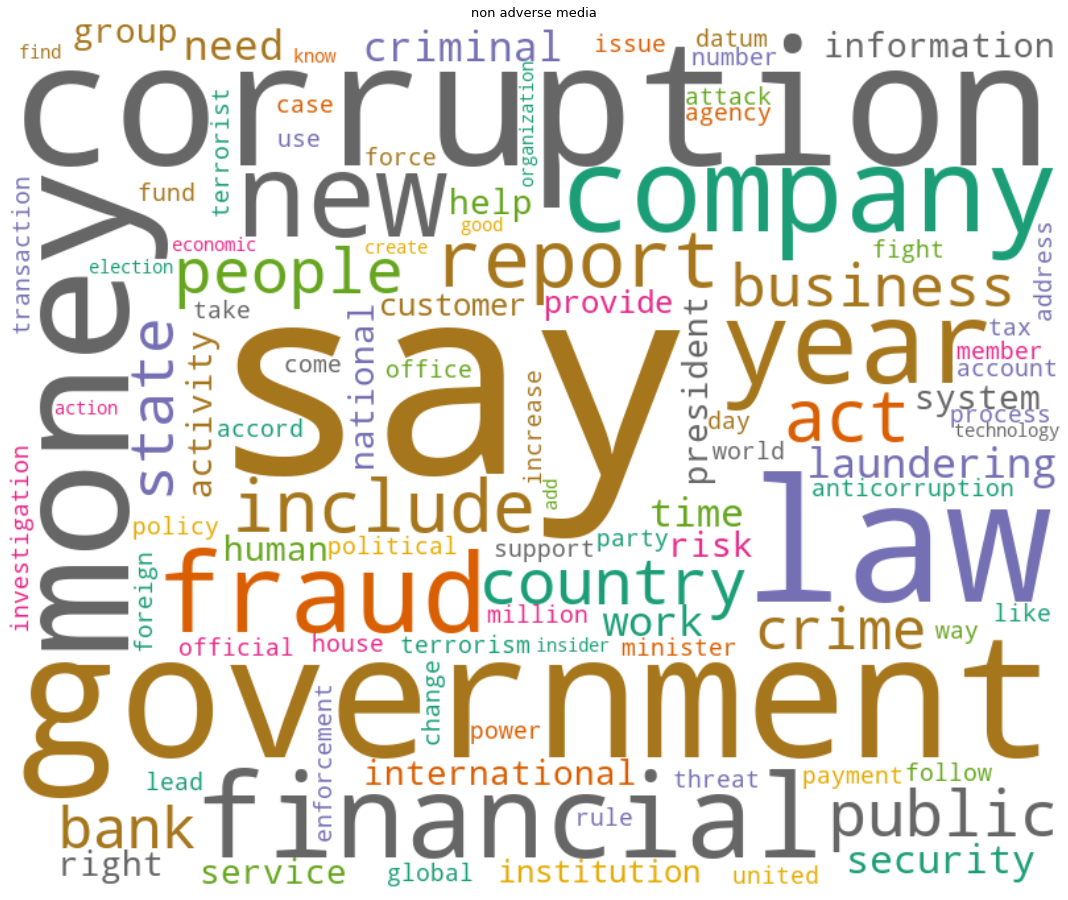

In [175]:
generate_wordclouds(unigram_dtm)

## Build word clouds for bigrams

In [176]:
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer(analyzer='word', ngram_range=(2,2))

data=cv.fit_transform([am_all_lemmas, nam_all_lemmas])
bigram_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
bigram_dtm.index = ['adverse media', 'non adverse media']
bigram_dtm.head(3)

,aa new,aaa rating,aaarated company,aabar investments,aadhaar card,aadhaar housing,aadhar card,aadhar number,aadmi party,aaii count,...,بوغيث bear,سليمان بوغيث,صالح عيسى,عقيلة صالح,عيسى bear,ماهان romanize,مصطفى الكاظمي,هواپیمایی ماهان,吳立勝 pinyin,新建业集团 member
adverse media,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,0,1,1,1
non adverse media,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,0,0,0


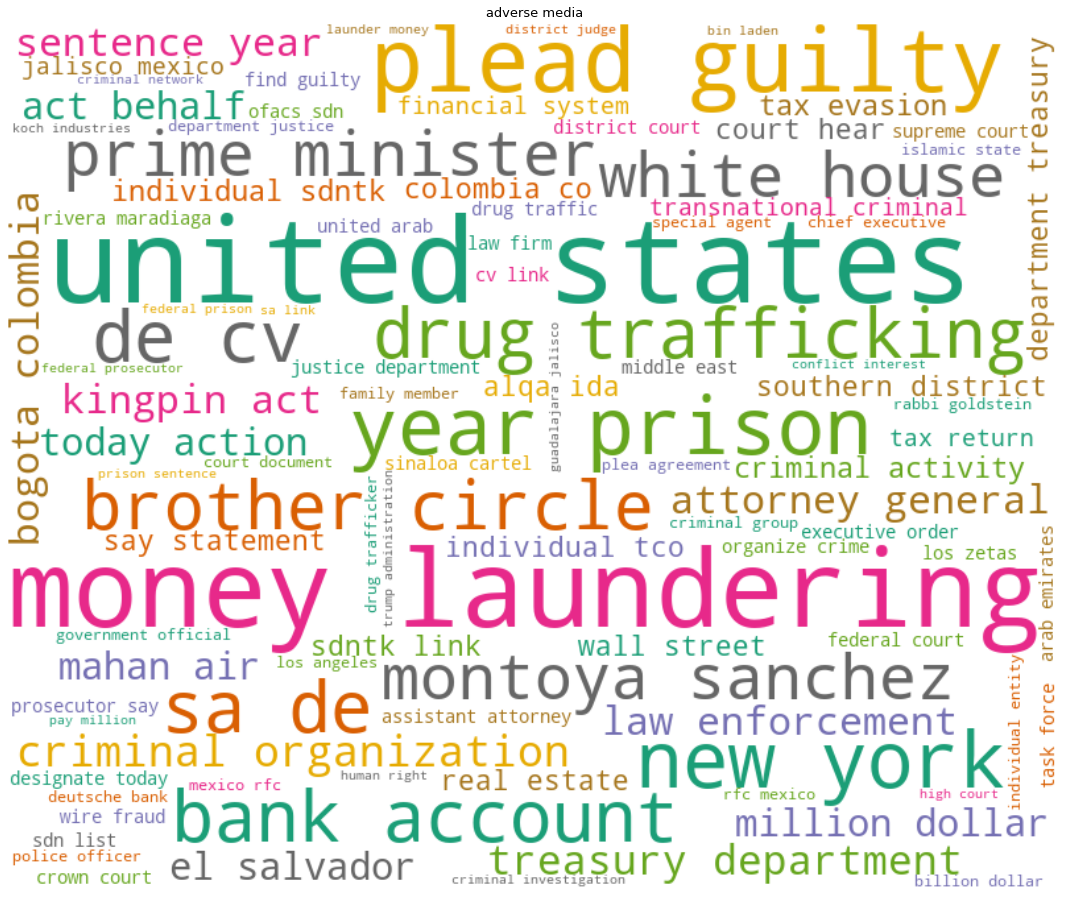

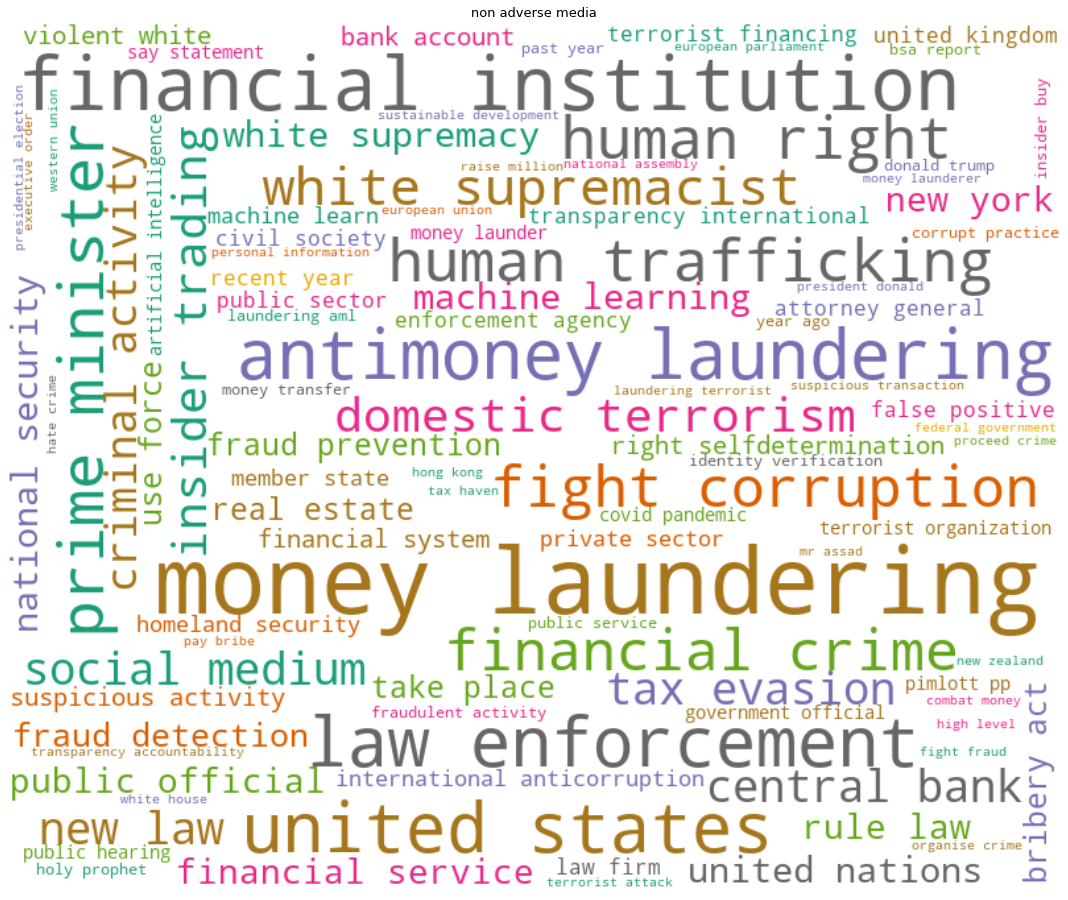

In [178]:
generate_wordclouds(bigram_dtm)